In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotting.lare_matplot as lmp

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("data/clean_data/LAPD_RIPA_DATA_202101_202206.csv'", encoding = 'unicode_escape', engine ='python')
df["stopDateTime"] = pd.to_datetime(df["stopDateTime"], format="%Y-%m-%d %H:%M:%S")
std_cols = {"stopID": "stop_id",
            "stopDateTime": "date_time",
            "stopDuration": "duration",
            "stopInResponseToCFS": "call_for_service",
           "street": "location",
           "actionTakenDuringStop": "actions_taken",
           "personSearchConsentGiven": "person_search_consent",
           "propertySearchConsentGiven": "property_search_consent",
           "perceivedRace": "race",
           "reasonForStop": "reason_for_stop",
           "perceivedOrKnownDisability": "disabilities",
            "perceivedLimitedEnglish": "limited_english",
            "perceivedAge": "age",
            "perceivedGender": "gender",
            "perceivedLgbt": "lgbt",
            "genderNonConforming": "gender_nonconforming",
            "resultOfStop": "result",
            "basisForSearch": "basis_for_search",
            "contrabandOrEvidenceDiscovered": "evidence_found"
           }
df.rename(columns=std_cols, inplace="True")

FileNotFoundError: [Errno 2] No such file or directory: "data/clean_data/LAPD_RIPA_DATA_202101_202206.csv'"

Make a list of all the possible results, in increasing order of severity. We'll use this to sort, then we'll select the single record for each stop_id with the most sever outcome.

In [4]:
orig_df_uniq=df.drop_duplicates(subset="stop_id", keep="last")

In [5]:
result_options = ['No Action',
                 'Warning (verbal or written)',
                 'Noncriminal transport or caretaking transport',
                 'Psychiatric hold',
                 'Field interview card completed',
                 'Contacted parent/legal guardian or other person responsible for the minor',
                 'Citation for infraction',
                 'In-field cite and release',
                 'Custodial Arrest pursuant to outstanding warrant',
                 'Custodial Arrest without warrant']

In [6]:
df["result_num"] = df["result"].apply(lambda x: result_options.index(x))

In [7]:
df.sort_values(by=["stop_id", "result_num"], inplace=True)

In [8]:
df_uniq = df.drop_duplicates(subset="stop_id", keep="last")

In [9]:
len(df_uniq)

738

In [10]:
df_uniq["result"].value_counts()

Warning (verbal or written)                                                  406
Citation for infraction                                                      237
No Action                                                                     52
In-field cite and release                                                     20
Custodial Arrest pursuant to outstanding warrant                               8
Custodial Arrest without warrant                                               6
Noncriminal transport or caretaking transport                                  3
Field interview card completed                                                 3
Psychiatric hold                                                               2
Contacted parent/legal guardian or other person responsible for the minor      1
Name: result, dtype: int64

In [11]:
orig_df_uniq["result"].value_counts()

Warning (verbal or written)                                                  416
Citation for infraction                                                      233
No Action                                                                     53
In-field cite and release                                                     16
Custodial Arrest without warrant                                               6
Custodial Arrest pursuant to outstanding warrant                               6
Noncriminal transport or caretaking transport                                  3
Field interview card completed                                                 2
Psychiatric hold                                                               2
Contacted parent/legal guardian or other person responsible for the minor      1
Name: result, dtype: int64

In [12]:
import analysis.populations as pop

In [13]:
la_pop=pop.get_population("Los Altos")

In [14]:
la_pop_df = la_pop.to_frame("pop")

In [15]:
stops = df_uniq["race"].value_counts()

In [16]:
stops_df=stops.to_frame("stops")

In [17]:
sns.reset_defaults()
sns.set_style("white")

In [18]:
ax = sns.scatterplot(data=pd.concat([la_pop_df, stops_df], sort=False, axis=1), 
                x="pop", 
                y="stops")
ax.set(xlabel="Population", ylabel="Number of Stops")
plt.plot([0, la_pop["White"]], [0,stops["White"]], linestyle="dashed", color="xkcd:grey")
for race in stops.keys():
    plt.annotate("{} ({:.1f}%)".format(race, 100*stops[race]/la_pop[race]), (la_pop[race]+250, stops[race]) )
plt.annotate("↑ Excessive Stops ↑", (11000, 190), rotation=37, color="red")
sns.despine()
ax.figure.savefig("stops_vs_population.png", bbox_inches="tight")

/tmp/ipykernel_46878/1206384643.py:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.annotate("{} ({:.1f}%)".format(race, 100*stops[race]/la_pop[race]), (la_pop[race]+250, stops[race]) )


In [21]:
rel_bars = (df_uniq["race"].value_counts()/la_pop)/(df_uniq["race"].value_counts()["White"]/la_pop["White"])

In [22]:
rel_bars_df = rel_bars.to_frame("relative")

In [23]:
rel_bars_df["err"] = (np.sqrt(df_uniq["race"].value_counts())/la_pop)/(df_uniq["race"].value_counts()["White"]/la_pop["White"])

In [24]:
rel_bars_df

,relative,err
Asian,1.282735,0.108800
Black/African American,12.408296,2.344948
Hispanic/Latino/a,9.091666,0.656135
Middle Eastern or South Asian,2.229333,0.233698
Multiple,NaN,NaN
Native American,5.354771,3.786395
Other,NaN,NaN
Pacific Islander,inf,inf
White,1.000000,0.060193


In [25]:
rel_bars_clean_df = rel_bars_df.dropna()[rel_bars < 1e30] #.to_frame("relative")

/tmp/ipykernel_46878/2446174790.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rel_bars_clean_df = rel_bars_df.dropna()[rel_bars < 1e30] #.to_frame("relative")


In [26]:
rel_bars_clean_df

,relative,err
Asian,1.282735,0.108800
Black/African American,12.408296,2.344948
Hispanic/Latino/a,9.091666,0.656135
Middle Eastern or South Asian,2.229333,0.233698
Native American,5.354771,3.786395
White,1.000000,0.060193


In [27]:
ax = sns.barplot(rel_bars_clean_df, x="relative", y=rel_bars_clean_df.index.values,
                xerr=rel_bars_clean_df["err"])
ax.set(xlabel="Relative per-capita rate of stops (White = 1)")
ax.figure.savefig("relative_per_capita_rate_bar.png", bbox_inches="tight")

In [28]:
import analysis.ratios as rat

In [29]:
new_whites = rat.add_races(df_uniq, ['White'])

In [30]:
df_uniq[df_uniq["race"]=="White"]["result"].value_counts()

Warning (verbal or written)                                                  158
Citation for infraction                                                       78
No Action                                                                     23
Custodial Arrest pursuant to outstanding warrant                               6
In-field cite and release                                                      5
Custodial Arrest without warrant                                               2
Psychiatric hold                                                               2
Contacted parent/legal guardian or other person responsible for the minor      1
Noncriminal transport or caretaking transport                                  1
Name: result, dtype: int64

In [31]:
df_uniq[df_uniq["race"]=="Black/African American"]["result"].value_counts()

Warning (verbal or written)                      17
Citation for infraction                           5
No Action                                         3
In-field cite and release                         2
Noncriminal transport or caretaking transport     1
Name: result, dtype: int64

In [32]:
df_uniq[df_uniq["race"]=="Hispanic/Latino/a"]["result"].value_counts()

Warning (verbal or written)                         106
Citation for infraction                              58
No Action                                            12
In-field cite and release                            10
Custodial Arrest without warrant                      3
Custodial Arrest pursuant to outstanding warrant      2
Field interview card completed                        1
Name: result, dtype: int64

In [33]:
df_uniq[df_uniq["result"]=="Custodial Arrest without warrant"]["race"].value_counts()

Hispanic/Latino/a    3
White                2
Pacific Islander     1
Name: race, dtype: int64

In [34]:
pt = pd.pivot_table(df_uniq, values="stop_id", index="race", columns="result", aggfunc="count", fill_value=0)

In [35]:
pt["warn/help"] = pt["Warning (verbal or written)"] + \
                    pt["Psychiatric hold"] + \
                    pt["Noncriminal transport or caretaking transport"] + \
                    pt["Field interview card completed"]

In [36]:
pt["cite/arrest"] = pt["Citation for infraction"] + \
                    pt["Custodial Arrest pursuant to outstanding warrant"] + \
                    pt["Custodial Arrest without warrant"] + \
                    pt["In-field cite and release"]

In [37]:
pt

result,Citation for infraction,Contacted parent/legal guardian or other person responsible for the minor,Custodial Arrest pursuant to outstanding warrant,Custodial Arrest without warrant,Field interview card completed,In-field cite and release,No Action,Noncriminal transport or caretaking transport,Psychiatric hold,Warning (verbal or written),warn/help,cite/arrest
race,,,,,,,,,,,,
Asian,57,0,0,0,1,1,8,1,0,71,73,58
Black/African American,5,0,0,0,0,2,3,1,0,17,18,7
Hispanic/Latino/a,58,0,2,3,1,10,12,0,0,106,107,73
Middle Eastern or South Asian,36,0,0,0,0,1,5,0,0,49,49,37
Native American,0,0,0,0,0,1,1,0,0,0,0,1
Pacific Islander,3,0,0,1,1,0,0,0,0,5,6,4
White,78,1,6,2,0,5,23,1,2,158,161,91


In [38]:
bob = pt[["No Action", "warn/help", "cite/arrest"]]

In [39]:
bob = bob.transpose()

In [40]:
bob

race,Asian,Black/African American,Hispanic/Latino/a,Middle Eastern or South Asian,Native American,Pacific Islander,White
result,,,,,,,
No Action,8,3,12,5,1,0,23
warn/help,73,18,107,49,0,6,161
cite/arrest,58,7,73,37,1,4,91


In [45]:
bob["Black/African American"].sum()

28

In [46]:
bob["White"].sum()

275

In [47]:
import analysis.bayes_binomial as bayes

In [48]:
bayes.odds_different(3, 28, 23, 275)

0.16420886485863948

In [49]:
bayes.odds_different(12, 12+107+73, 23, 275)

0.08709590081766072

In [50]:
bayes.odds_different(23, 275, 3, 28)

0.16420886485863948

In [51]:
bayes.odds_different(23, 275, 12, 12+107+73)

0.08709590081766072

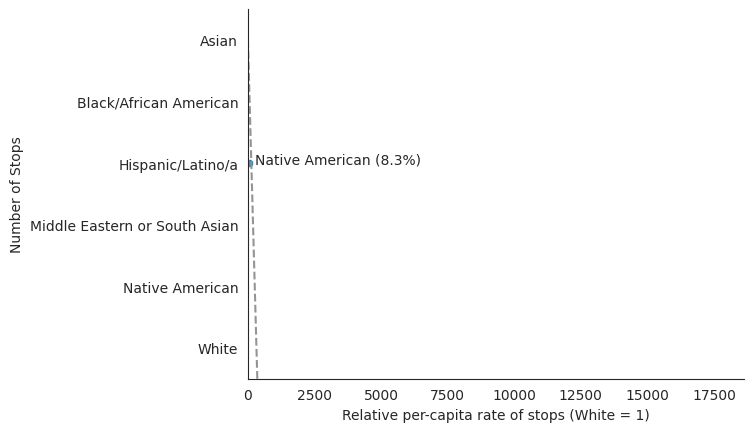

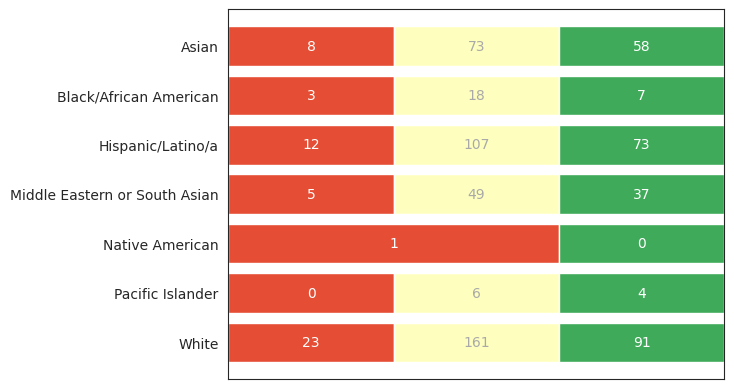

In [41]:
keys = bob.keys() #["No Action", "warn/help", "cite/arrest"]
fig = plt.subplots(len(keys), 1)
for key in keys:
    lmp.single_bar(bob[key], key, fig, 1, 1)
plt.show()



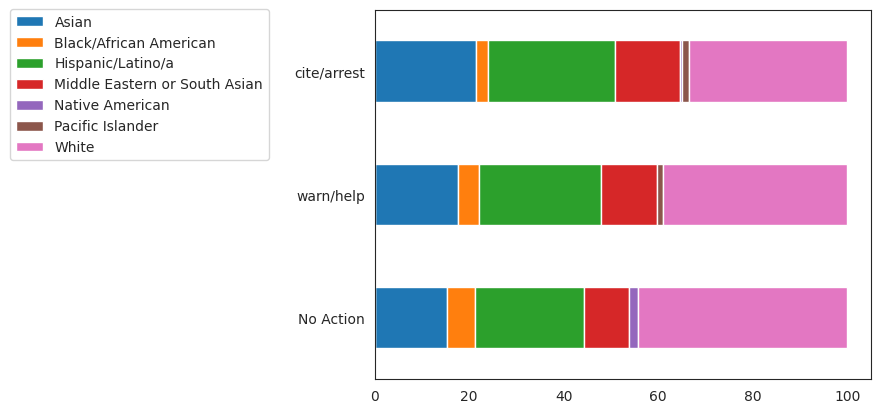

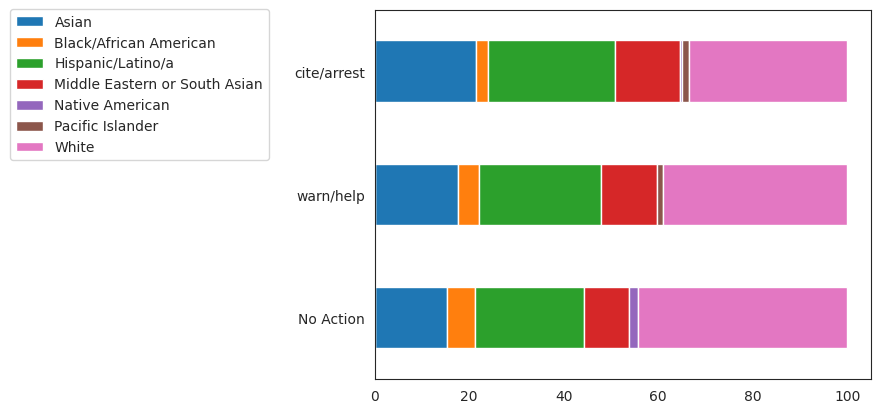

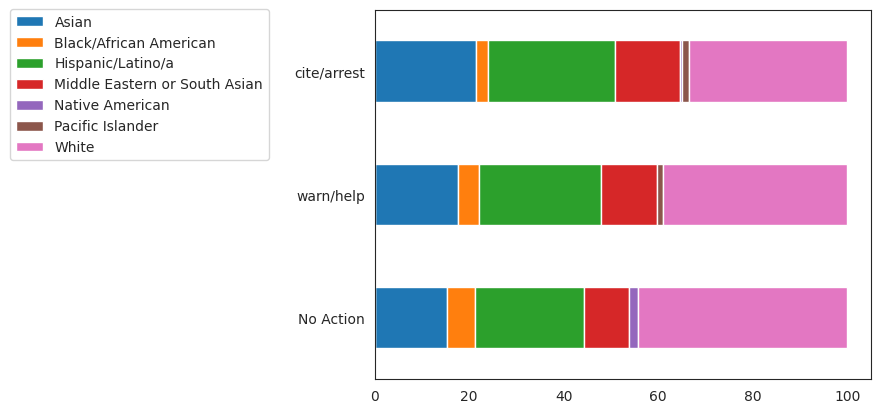

In [44]:
ax = bob.div(0.01*bob.sum(axis=1), axis=0).plot(kind='barh',stacked=True,rot=0)
ax.set(ylabel="")
ax.legend(bbox_to_anchor=(-0.2, 1.02))
plt.show()


In [266]:
bob.keys()

Index(['No Action', 'warn/help', 'cite/arrest'], dtype='object', name='result')

In [269]:
bobt=bob.transpose()

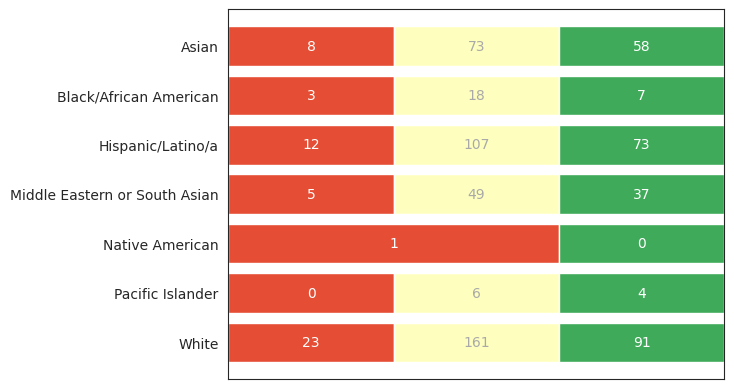

In [270]:
fig = plt.subplots(len(bobt.keys()), 1)
for key in bobt.keys():
    lmp.single_bar(bobt[key], key, fig, 1, 1)
plt.show()

In [121]:
whites

Citation for infraction                                                       77.0
Contacted parent/legal guardian or other person responsible for the minor      1.0
Custodial Arrest pursuant to outstanding warrant                               6.0
Custodial Arrest without warrant                                               2.0
Field interview card completed                                                 0.0
In-field cite and release                                                      4.0
No Action                                                                     23.0
Noncriminal transport or caretaking transport                                  1.0
Psychiatric hold                                                               2.0
Warning (verbal or written)                                                  157.0
dtype: float64

In [173]:
new_whites

Citation for infraction                                                       78.0
Contacted parent/legal guardian or other person responsible for the minor      1.0
Custodial Arrest pursuant to outstanding warrant                               6.0
Custodial Arrest without warrant                                               2.0
Field interview card completed                                                 0.0
In-field cite and release                                                      5.0
No Action                                                                     23.0
Noncriminal transport or caretaking transport                                  1.0
Psychiatric hold                                                               2.0
Warning (verbal or written)                                                  158.0
dtype: float64

In [128]:
df[df["stop_id"]==3140]["result"].value_counts()

In-field cite and release    36
Name: result, dtype: int64

In [135]:
result_options = list(df["result"].value_counts().index.values)

In [136]:
result_options.index("No Action")

5

In [137]:
result_options

['Warning (verbal or written)',
 'Custodial Arrest without warrant',
 'Citation for infraction',
 'In-field cite and release',
 'Custodial Arrest pursuant to outstanding warrant',
 'No Action',
 'Psychiatric hold',
 'Noncriminal transport or caretaking transport',
 'Field interview card completed',
 'Contacted parent/legal guardian or other person responsible for the minor']

In [155]:
test_stop = 3133

In [157]:
df[df["stop_id"] == test_stop]["result"].values[0]

'Custodial Arrest pursuant to outstanding warrant'

In [158]:
result_options.index(df[df["stop_id"] == test_stop]["result"].values[0])

8

In [165]:
df[df["stop_id"]==3133]

,stop_id,date_time,duration,call_for_service,location,actions_taken,person_search_consent,property_search_consent,race,reason_for_stop,disabilities,limited_english,age,gender,lgbt,genderNonconforming,result,basis_for_search,evidence_found,result_num
32,3133,2022-01-13 15:51:35,30,True,homestead rd,Curbside detention,NaN,NaN,White,Reasonable Suspicion,Mental health condition,False,35,Male,No,False,In-field cite and release,Incident to arrest,None,7
34,3133,2022-01-13 15:51:35,30,True,homestead rd,Handcuffed or flex cuffed,NaN,NaN,White,Reasonable Suspicion,Mental health condition,False,35,Male,No,False,In-field cite and release,Incident to arrest,None,7
35,3133,2022-01-13 15:51:35,30,True,homestead rd,Patrol car detention,NaN,NaN,White,Reasonable Suspicion,Mental health condition,False,35,Male,No,False,In-field cite and release,Incident to arrest,None,7
37,3133,2022-01-13 15:51:35,30,True,homestead rd,Search of person was conducted,NaN,NaN,White,Reasonable Suspicion,Mental health condition,False,35,Male,No,False,In-field cite and release,Incident to arrest,None,7
30,3133,2022-01-13 15:51:35,30,True,homestead rd,Handcuffed or flex cuffed,NaN,NaN,White,Reasonable Suspicion,Mental health condition,False,35,Male,No,False,Custodial Arrest pursuant to outstanding warrant,Incident to arrest,None,8
31,3133,2022-01-13 15:51:35,30,True,homestead rd,Search of person was conducted,NaN,NaN,White,Reasonable Suspicion,Mental health condition,False,35,Male,No,False,Custodial Arrest pursuant to outstanding warrant,Incident to arrest,None,8
33,3133,2022-01-13 15:51:35,30,True,homestead rd,Curbside detention,NaN,NaN,White,Reasonable Suspicion,Mental health condition,False,35,Male,No,False,Custodial Arrest pursuant to outstanding warrant,Incident to arrest,None,8
36,3133,2022-01-13 15:51:35,30,True,homestead rd,Patrol car detention,NaN,NaN,White,Reasonable Suspicion,Mental health condition,False,35,Male,No,False,Custodial Arrest pursuant to outstanding warrant,Incident to arrest,None,8
